In [51]:
# get model
from torchvision import models
import sys, torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from os.path import join as oj
import numpy as np
import pandas as pd
from copy import deepcopy
from memory_profiler import memory_usage
from timeit import timeit

%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model = models.vgg16(pretrained=True).to(device).eval()

# freeze the model
for param in model.parameters():
    param.requires_grad = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
## MLP which takes arguments for number of layers, sizes 
class FNN(nn.Module):
    def __init__(self, num_layers, input_size, hidden_size, output_size):
        # num_layers is number of weight matrices
        super(FNN, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        if num_layers == 1:
            self.fc = nn.ModuleList([nn.Linear(input_size, self.output_size)])
        else:
            self.fc = nn.ModuleList([nn.Linear(input_size, hidden_size)])
            self.fc.extend([nn.Linear(hidden_size, hidden_size) for i in range(num_layers - 2)])
            self.fc.append(nn.Linear(hidden_size, self.output_size))
            
    # doesn't use last layer
    def features(self, x):
        y = x.view(-1, self.input_size)
        for i in range(len(self.fc) - 1):
            y = F.relu(self.fc[i](y))
        return y
        
    def forward(self, x): 
        return self.fc[-1](self.features(x)) # last layer has no relu

In [ ]:
def get_grad(m, im):
    pred = m(im).squeeze() # forward pass
    pred.backward(retain_graph=False) 
    print(pred)
    
def freeze(m):
    # freeze the model
    for param in m.parameters():
        param.requires_grad = False
    return m

# by default requires grad
input_size = 100
hidden_size = 100
num_iters = 50
device = 'cpu'

results = {'t': [], 't_freeze': [], 'm': [], 'm_freeze': []}
# for num_layers in [3, 5, 10, 25, 100, 500]:    
for input_size in [3, 5, 10, 25, 100, 500]:        
    im = torch.zeros(1, input_size, requires_grad=True, device=device)
    m = FNN(num_layers=num_layers, input_size=input_size, hidden_size=hidden_size, output_size=1)
    results['t'].append(timeit(lambda: get_grad(m, im), number=1))
    results['m'].append(max(memory_usage(lambda: get_grad(m, im))))
    m = freeze(m)
    results['t_freeze'].append(timeit(lambda: get_grad(m, im), number=1))
    results['m_freeze'].append(max(memory_usage(lambda: get_grad(m, im))))    
    
results = pd.DataFrame.from_dict(results)
results

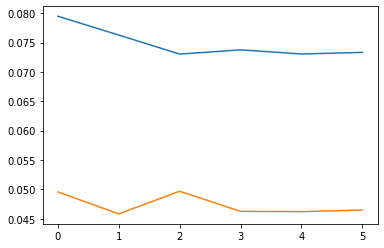

In [85]:
plt.plot(results['t'], label='normal')
plt.plot(results['t_freeze'], label='frozen')
plt.show()

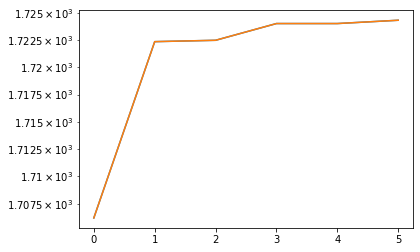

In [84]:
plt.plot(results['m'])
plt.plot(results['m_freeze'])
plt.yscale('log')